In [32]:
import numpy as np  # Importing NumPy for numerical operations and array manipulations
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting graphs and visualizations
import seaborn as sns  # Importing Seaborn for statistical data visualization, built on top of Matplotlib
import tensorflow as tf  # Importing TensorFlow for building and training machine learning models
from tensorflow import keras  # Importing Keras, a high-level API for TensorFlow, to simplify model building
from tensorflow.keras import Layer  # Importing Layer class for creating custom layers in Keras
from tensorflow.keras.models import Sequential  # Importing Sequential model for building neural networks layer-by-layer
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks  # Importing various modules for layers, optimizers, and callbacks in Keras
from sklearn.utils.class_weight import compute_class_weight  # Importing function to compute class weights for imbalanced datasets
from tensorflow.keras.applications import EfficientNetV2B2  # Importing EfficientNetV2S model for transfer learning
from sklearn.metrics import confusion_matrix, classification_report  # Importing functions to evaluate model performance
import gradio as gr  # Importin

In [33]:
dataset_dir= r"/home/abhinandan-yadav/Downloads/archive/garbage_classification"
image_size = (124, 124)
batch_size = 32
seed = 42

In [34]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)

Found 15515 files belonging to 12 classes.
Using 12412 files for training.


In [35]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)
val_class= val_ds.class_names


Found 15515 files belonging to 12 classes.
Using 3103 files for validation.


In [36]:
# Get the total number of batches in the validation dataset
val_batches = tf.data.experimental.cardinality(val_ds)  

# Split the validation dataset into two equal parts:
# First half becomes the test dataset
test_ds = val_ds.take(val_batches // 2)  

# Second half remains as the validation dataset
val_dat = val_ds.skip(val_batches // 2)  

# Optimize test dataset by caching and prefetching to improve performance
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)  


In [37]:
print(train_ds.class_names)
print(val_class)
print(len(train_ds.class_names))


['battery', 'bio_waste', 'br-glass', 'cdboard', 'clothes', 'gr-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
['battery', 'bio_waste', 'br-glass', 'cdboard', 'clothes', 'gr-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
12


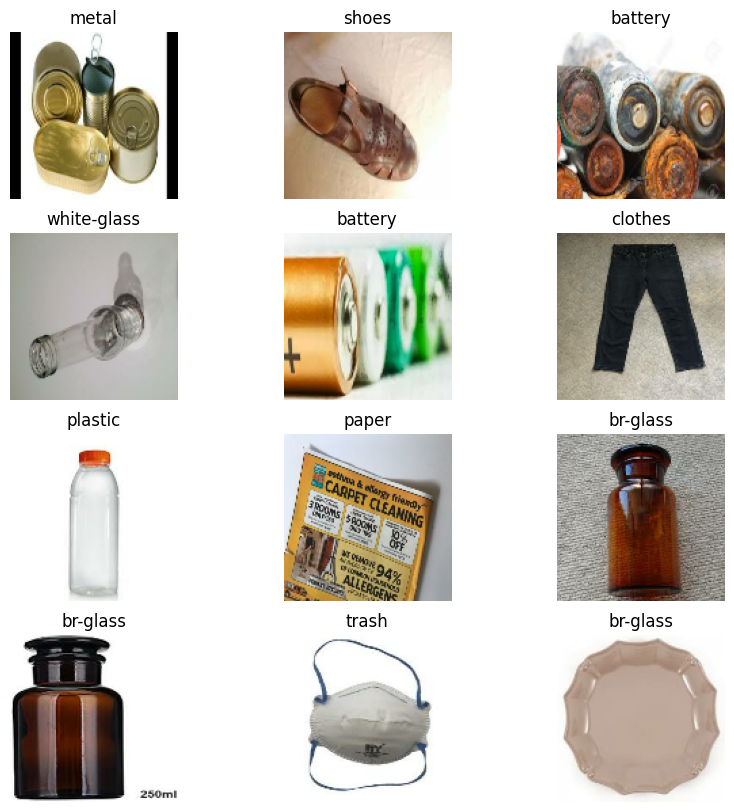

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")


In [39]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}
    
    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  # Convert to percentage
    return counts

In [40]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}
    
    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  # Convert to percentage
    return counts

In [41]:

print("Train dataset:", train_ds)
print("Validation dataset:", val_ds)
print("Test dataset:", test_ds)




Train dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 124, 124, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Validation dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 124, 124, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Test dataset: <_TakeDataset element_spec=(TensorSpec(shape=(None, 124, 124, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
print("Length of train_ds:", len(list(train_ds)))
print("Length of val_ds:", len(list(val_ds)))
print("Length of test_ds:", len(list(test_ds)))


In [ ]:
def count_distribution(ds, class_names):
    counts = {k: 0 for k in class_names}
    total = 0
    print("🔍 Debug: Starting to count distribution")

    for x, y in ds:
        print("✅ Found label:", y.numpy())
        label_index = y.numpy()
        
        if isinstance(label_index, list) or hasattr(label_index, '__len__'):
            label_index = label_index[0]

        if label_index >= len(class_names):
            print(f"⚠️ Warning: Invalid label index {label_index}")
            continue

        label = class_names[label_index]
        counts[label] += 1
        total += 1

    print("📊 Total items counted:", total)
    print("📈 Raw counts:", counts)

    if total == 0:
        print("❌ ERROR: No data found in dataset.")
        return {k: 0 for k in class_names}

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)

    return counts


In [ ]:
class_names = train_ds.class_names

# Get class distributions
train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
test_dist = count_distribution(test_ds, class_names)
overall_dist = {}
for k in class_names:
    overall_dist[k] = round((train_dist[k] + val_dist[k]) / 2, 2)

print(train_dist)
print(val_dist)
print(test_dist)
print(overall_dist)


🔍 Debug: Starting to count distribution
✅ Found label: [ 8  9  6  7  6  9  4  2  4 11  0  9 11  9  4  9  9  6  4  4  9  4  1 11
  7 10  6  9  4  8  8  9]
✅ Found label: [ 4  2  1  1  3  4  4  2  6  6  4  0  8  4  9  4  4  2  9  3 11 10  4  9
  6  3  5  4  1  3  9  9]
✅ Found label: [ 5  4  6  4  4  4  4  8  4  0  4  4 10  4 11 11 11  0  0  4  4 10  3  7
 10 10  9  3  4  6  4  6]
✅ Found label: [ 2  1  4  6  4  8  9  5  0  8  5  4  9  7  4 10 10  4  4 10  4 11  9  0
  1  3  4  6  8  6  4  3]
✅ Found label: [ 3  1  4  7  1  4  2  7  7  7  4  4  8  4  9  3  3  3  8  4  1  1  1  6
  5  0  4  4 11  4  4  0]
✅ Found label: [ 4  3 11  4  4  8  2  9  4  4  2  4  4 11  1  3  5  3  4  2  6  6  3  9
  3  6  8  4  4  4  4  4]
✅ Found label: [ 4  5  7  9  8  5  9  4  4  5  6  9  5  9  4  7  4  4  8  6 10  4  7  7
  4  5  6  4  4  7  4  6]
✅ Found label: [ 4  0  1 11  3  0  7  9  4  4  4  1  9  8 10 11  7  2  9  4  3  4  4 11
  5  3  6  0  0  8  3  4]
✅ Found label: [ 0  7  5  4  8  1  1  3  4  1  4

In [ ]:
import matplotlib.pyplot as plt

def simple_bar_plot(distribution, title):
    labels = list(distribution.keys())
    values = list(distribution.values())

    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, values, color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Percentage')
    plt.title(title)
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add value labels on top of bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval + 1, f'{yval}%', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()


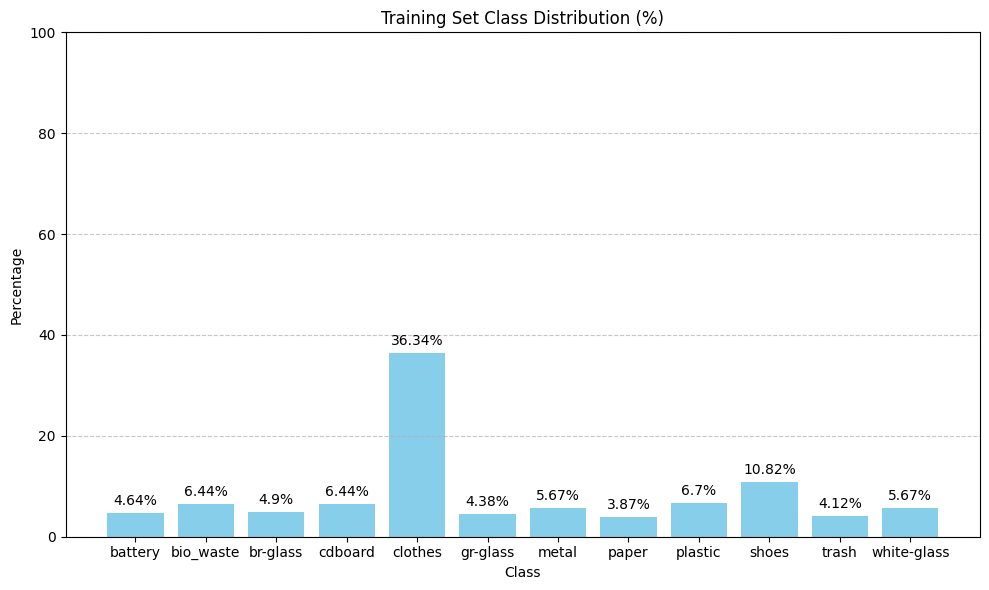

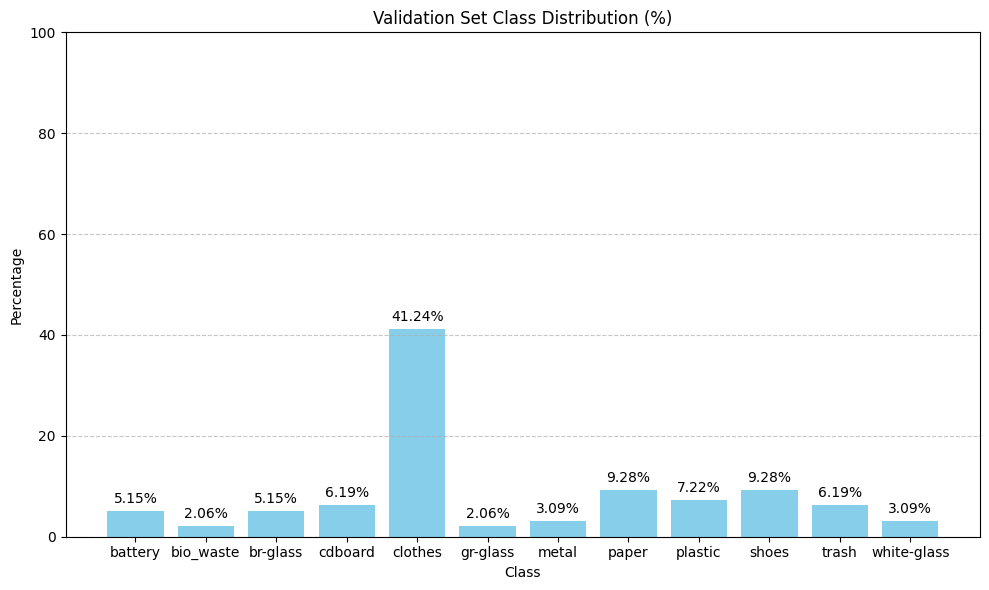

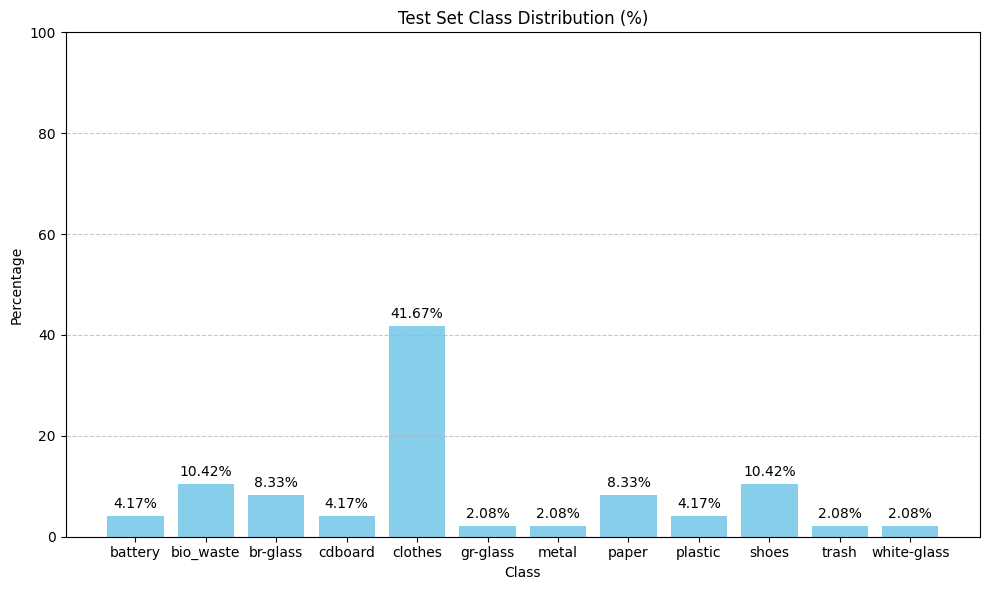

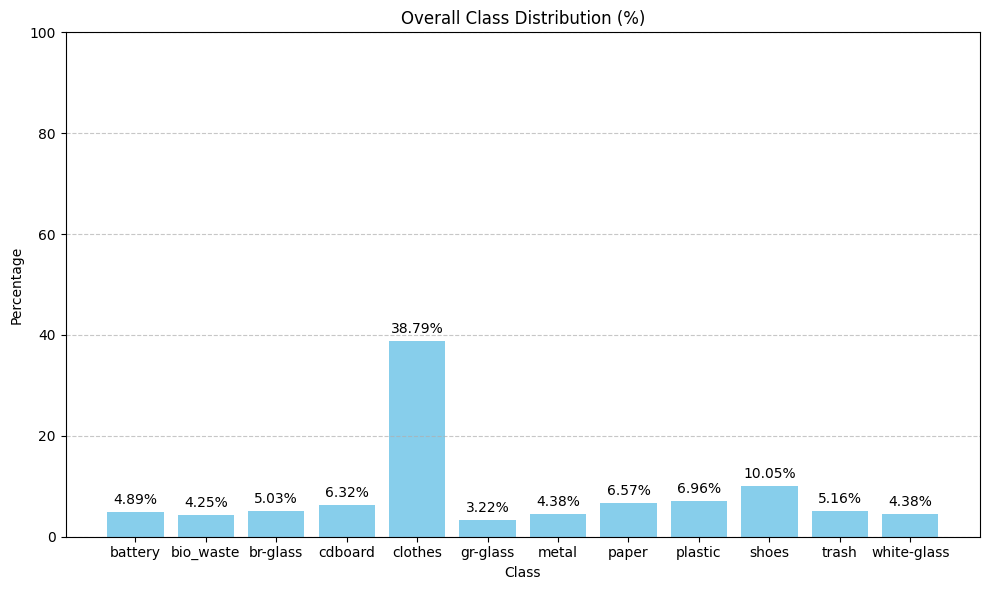

In [ ]:
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")
